# Interpolation of Sea Level Anomaly using GPSat
Week 8 contents can be accessed [here](https://drive.google.com/drive/folders/1E0mCn2xJw89O-UD7l9iEpZmlY3XwFWMl?usp=share_link).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Fetching data

In week 4, we've introduced the method to fetch different types of data from the Google Earth Engine and Copernicus Dataspace. The data we are going to use in this week's content is teh altimetry data. Therefore, we will use Copernicus Dataspace API instead of Google Earth Engine. Let's fetch this data and recall some of the procedures.


In [2]:
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 38.3 MB/s eta 0:00:00


In [3]:
import requests
import pandas as pd
import subprocess
import os
import time
import shutil
import json
from datetime import date
from joblib import Parallel, delayed
import zipfile
import sys
import glob
import numpy as np

def get_access_token(username, password):
    """
    Obtain an access token to the Copernicus Data Space Ecosystem.
    Necessary for the download of hosted products.
    """
    p =  subprocess.run(f"curl --location --request POST 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' \
            --header 'Content-Type: application/x-www-form-urlencoded' \
            --data-urlencode 'grant_type=password' \
            --data-urlencode 'username={username}' \
            --data-urlencode 'password={password}' \
            --data-urlencode 'client_id=cdse-public'", shell=True,capture_output=True, text=True)
    access_dict = json.loads(p.stdout)
    return access_dict['access_token'], access_dict['refresh_token']

#=============================================================================================================================================================#

def get_new_access_token(refresh_token):
    """
    Obtain a new access token to the Copernicus Data Space Ecosystem using a previously provided refesh token.
    """
    p =  subprocess.run(f"curl --location --request POST 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' \
    --header 'Content-Type: application/x-www-form-urlencoded' \
    --data-urlencode 'grant_type=refresh_token' \
    --data-urlencode 'refresh_token={refresh_token}' \
    --data-urlencode 'client_id=cdse-public'", shell=True,capture_output=True, text=True)
    access_dict = json.loads(p.stdout)
    return access_dict['access_token'], access_dict['refresh_token']

#=============================================================================================================================================================#

def get_S3_products_by_names(names):
    """
    Obtain a pandas dataframe of Sentinel products for a given list of product names.
    """
    all_results = []

    base_url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter="

    for name in names:
        query_url = f"{base_url}Name eq '{name}'&$top=1000"

        response = requests.get(query_url)
        json_response = response.json()

        if 'value' in json_response:
            all_results.extend(json_response['value'])

    results_df = pd.DataFrame.from_dict(all_results)

    if not results_df.empty:
        results_df['Satellite'] = [row['Name'][:3] for i, row in results_df.iterrows()]
        results_df['SensingStart'] = [pd.to_datetime(row['ContentDate']['Start']) for i, row in results_df.iterrows()]
        results_df['SensingEnd'] = [pd.to_datetime(row['ContentDate']['End']) for i, row in results_df.iterrows()]
        results_df = results_df.sort_values(by='SensingStart')

    return results_df

def download_single_product(product_id, file_name, access_token, download_dir="downloaded_products"):
    """
    Download a single product from the Copernicus Data Space.

    :param product_id: The unique identifier for the product.
    :param file_name: The name of the file to be downloaded.
    :param access_token: The access token for authorization.
    :param download_dir: The directory where the product will be saved.
    """
    # Ensure the download directory exists
    os.makedirs(download_dir, exist_ok=True)

    # Construct the download URL
    url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"

    # Set up the session and headers
    headers = {"Authorization": f"Bearer {access_token}"}
    session = requests.Session()
    session.headers.update(headers)

    # Perform the request
    response = session.get(url, headers=headers, stream=True)

    # Check if the request was successful
    if response.status_code == 200:
        # Define the path for the output file
        output_file_path = os.path.join(download_dir, file_name + ".zip")

        # Stream the content to a file
        with open(output_file_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
        print(f"Downloaded: {output_file_path}")
    else:
        print(f"Failed to download product {product_id}. Status Code: {response.status_code}")

In [ ]:
cop_dspace_usrnm = '' # amend with your copernicus dataspace username
cop_dspace_psswrd = ''# amend with your copernicus dataspace password
token, refresh_token = get_access_token(cop_dspace_usrnm, cop_dspace_psswrd)
product_names = [
    "S3A_SR_2_WAT____20230101T185252_20230101T185651_20230101T203101_0239_094_027______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230101T121709_20230101T122349_20230101T135934_0400_094_023______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230102T182657_20230102T183045_20230102T200425_0228_094_041______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230102T115112_20230102T115751_20230102T132929_0399_094_037______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230105T121326_20230105T122007_20230105T134843_0401_094_080______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230105T184910_20230105T185308_20230105T202752_0238_094_084______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230106T182316_20230106T182702_20230106T200253_0226_094_098______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230109T120945_20230109T121625_20230109T135020_0400_094_137______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230103T122643_20230103T123314_20230103T140329_0391_074_294______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230104T183621_20230104T184014_20230104T201141_0233_074_312______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230107T122257_20230107T122931_20230107T135514_0394_074_351______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230107T185833_20230107T190234_20230107T203555_0240_074_355______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230108T183238_20230108T183630_20230108T200807_0232_074_369______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230108T115654_20230108T120333_20230108T133905_0399_074_365______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230111T185450_20230111T185850_20230111T202939_0240_075_027______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230111T121911_20230111T122547_20230111T135219_0396_075_023______MAR_O_NR_005.SEN3"
]

results_df = get_S3_products_by_names(product_names)
print(results_df)




     @odata.mediaContentType                                    Id  \
1   application/octet-stream  df44f31a-61d2-5964-838b-816a54e39e43   
0   application/octet-stream  ccd45b65-52f8-5761-a43a-5909c6b05cc4   
3   application/octet-stream  eef92190-f150-5f99-b61d-6fe53bac377a   
2   application/octet-stream  30e00559-06fb-57f4-9960-544f0f036439   
8   application/octet-stream  68339973-c768-5475-a93f-20b271d53880   
9   application/octet-stream  e7247cfb-ad7c-59ed-80cb-a86f7ca8a5f7   
4   application/octet-stream  f9d13b5d-3ad2-5723-bd0e-2a9f3a685797   
5   application/octet-stream  596577bf-a7eb-5ad3-974a-45e7819244c9   
6   application/octet-stream  e7c0673a-7102-5025-ac1b-d989957274e0   
10  application/octet-stream  d4cc75e3-d55e-5a77-bb26-35efe4f6f918   
11  application/octet-stream  fc0101b5-a4a1-5a1c-9221-ef07a816ed1c   
13  application/octet-stream  45b2e256-9995-5ac3-8070-bfcd00e8e026   
12  application/octet-stream  65b1891a-60ca-5241-b5a8-96aa428b8838   
7   application/octe

Now we download all files altogether.

In [ ]:
# Assuming download_single_product is a function that takes product_id, file_name, token, and download_dir as arguments

download_dir = '/Users/weibinchen/Desktop/UCL/PhD_Year_1/Data/'

# Loop through each row in the DataFrame
for index, row in results_df.iterrows():
    product_id = row['Id']
    file_name = row['Name']

    # Call the download function for each product
    download_single_product(product_id, file_name, token, download_dir)


Downloaded: /Users/weibinchen/Desktop/UCL/PhD_Year_1/Data/S3A_SR_2_WAT____20230101T121709_20230101T122349_20230101T135934_0400_094_023______MAR_O_NR_005.SEN3.zip
Downloaded: /Users/weibinchen/Desktop/UCL/PhD_Year_1/Data/S3A_SR_2_WAT____20230101T185252_20230101T185651_20230101T203101_0239_094_027______MAR_O_NR_005.SEN3.zip
Downloaded: /Users/weibinchen/Desktop/UCL/PhD_Year_1/Data/S3A_SR_2_WAT____20230102T115112_20230102T115751_20230102T132929_0399_094_037______MAR_O_NR_005.SEN3.zip
Downloaded: /Users/weibinchen/Desktop/UCL/PhD_Year_1/Data/S3A_SR_2_WAT____20230102T182657_20230102T183045_20230102T200425_0228_094_041______MAR_O_NR_005.SEN3.zip
Downloaded: /Users/weibinchen/Desktop/UCL/PhD_Year_1/Data/S3B_SR_2_WAT____20230103T122643_20230103T123314_20230103T140329_0391_074_294______MAR_O_NR_005.SEN3.zip
Downloaded: /Users/weibinchen/Desktop/UCL/PhD_Year_1/Data/S3B_SR_2_WAT____20230104T183621_20230104T184014_20230104T201141_0233_074_312______MAR_O_NR_005.SEN3.zip
Downloaded: /Users/weibinche

By this stage, you should have all the Sentinel-3 files prepared for your analysis. If you need to locate additional files, the [Copernicus Data Space Browser](https://browser.dataspace.copernicus.eu/?zoom=5&lat=50.16282&lng=20.78613&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2Fa91f72b5-f393-4320-bc0f-990129bd9e63&datasetId=S2_L2A_CDAS&demSource3D=%22MAPZEN%22&cloudCoverage=30&dateMode=SINGLE) is an invaluable tool for pinpointing files in specific regions.

### Step 1: Product Selection
Begin by choosing the desired data products. For our purposes, select the SENTINEL-3/SRAL/Level-2 WAT dataset.
![Data Selection Interface](./image1.png)

You can also define the temporal scope of your search by setting the desired date range.
![Date Range Selection](./image2.png)

### Step 2: Defining the Region of Interest
Use the polygon tool to demarcate your area of interest on the map.
![Region Drawing Tool](./image_3.png)

### Step 3: Initiating the Search
With the chosen products, defined time span, and spatial parameters set, the browser will retrieve a list of files that match your criteria.
![Search Results Interface](./image4.png)
![File List Interface](./image5.png)


## SLA Interpolation

Now, the data is all set and we can proceed with the interpolation.

In [4]:
! pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.3 MB/s eta 0:00:00


In [5]:
from netCDF4 import Dataset

In [6]:
path = '/content/drive/MyDrive/Teaching_Michel/GEOL0069/StudentFolder/Week_8/Data/'
SAR_file='S3A_SR_2_WAT____20230101T121709_20230101T122349_20230101T135934_0400_094_023______MAR_O_NR_005.SEN3'
SAR_data=Dataset(path + SAR_file+'/enhanced_measurement.nc')

In [ ]:
SAR_data.variables.keys()

In [8]:
import matplotlib.pyplot as plt


In [9]:
SAR_data['ssha_20_ku'].shape

(7860,)

In [10]:
SAR_data['ssha_01_ku'].shape

(401,)

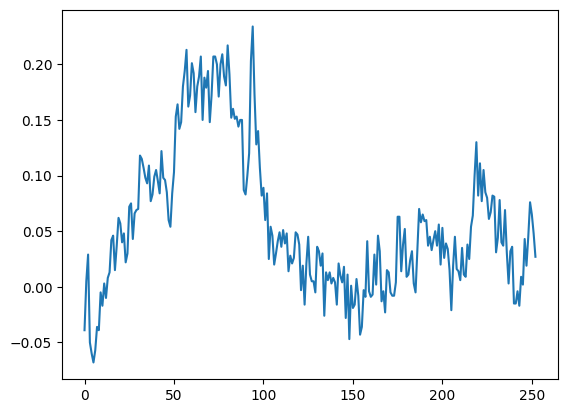

In [11]:
plt.plot(np.asarray(SAR_data['ssha_01_ku'][np.abs(SAR_data['ssha_01_ku'])<0.3]))

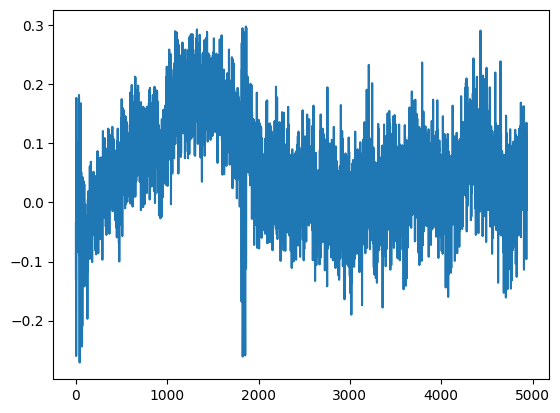

In [21]:
plt.plot(np.asarray(SAR_data['ssha_20_ku'][np.abs(SAR_data['ssha_20_ku'])<0.3]))

In [12]:
SAR_data['lon_20_ku'].shape

(7860,)

In [13]:
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pyproj import Transformer

# Define the transformation function
def WGS84toEASE2_Vectorized(lon, lat, return_vals="both", lon_0=0, lat_0=-90):
    EASE2 = f"+proj=laea +lon_0={lon_0} +lat_0={lat_0} +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
    WGS84 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    transformer = Transformer.from_crs(WGS84, EASE2)
    x, y = transformer.transform(lon, lat)
    if return_vals == 'both':
        return x, y
def EASE2toWGS84(x, y, return_vals="both", lon_0=0, lat_0=-90):

    valid_return_vals = ['both', 'lon', 'lat']
    assert return_vals in ['both', 'lon', 'lat'], f"return_val: {return_vals} is not in valid set: {valid_return_vals}"
    EASE2 = f"+proj=laea +lon_0={lon_0} +lat_0={lat_0} +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
    WGS84 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    transformer = Transformer.from_crs(EASE2, WGS84)
    lon, lat = transformer.transform(x, y)
    if return_vals == "both":
        return lon, lat
    elif return_vals == "lon":
        return lon
    elif return_vals == "lat":
        return lat

def get_projection(projection=None):

    # projection
    if projection is None:
        projection = ccrs.NorthPolarStereo()
    elif isinstance(projection, ccrs.Projection):
        pass
    elif isinstance(projection, str):
        if re.search("north", projection, re.IGNORECASE):
            projection = ccrs.NorthPolarStereo()
        elif re.search("south", projection, re.IGNORECASE):
            projection = ccrs.SouthPolarStereo()
        else:
            raise NotImplementedError(f"projection provide as str: {projection}, not implemented")

    return projection
def plot_pcolormesh(ax, lon, lat, plot_data,
                    fig=None,
                    title=None,
                    vmin=None,
                    vmax=None,
                    qvmin=None,
                    qvmax=None,
                    cmap='YlGnBu_r',
                    cbar_label=None,
                    scatter=False,
                    extent=None,
                    ocean_only=False,
                    **scatter_args):

    # ax = axs[j]
    ax.coastlines(resolution='50m', color='white')
    ax.add_feature(cfeat.LAKES, color='white', alpha=.5)
    ax.add_feature(cfeat.LAND, color=(0.8, 0.8, 0.8))
    # extent=[10, -150, -80, -67] if extent is None else extent
    extent = [-180, 180, 60, 90] if extent is None else extent
    ax.set_extent(extent, ccrs.PlateCarree())  # lon_min,lon_max,lat_min,lat_max

    if title:
        ax.set_title(title)

    if ocean_only:
        if globe_mask is None:
            warnings.warn(f"ocean_only={ocean_only}, however globe_mask is missing, "
                          f"install with pip install global-land-mask")
        else:
            is_in_ocean = globe_mask.is_ocean(lat, lon)
            # copy, just to be safe
            plot_data = copy.copy(plot_data)
            plot_data[~is_in_ocean] = np.nan

    if qvmin is not None:
        if vmin is not None:
            warnings.warn("both qvmin and vmin are supplied, only using qvmin")
        assert (qvmin >= 0) & (qvmin <= 1.0), f"qvmin: {qvmin}, needs to be in [0,1]"
        vmin = np.nanquantile(plot_data, q=qvmin)

    if qvmax is not None:
        if vmax is not None:
            warnings.warn("both qvmax and vmax are supplied, only using qvmax")
        assert (qvmax >= 0) & (qvmax <= 1.0), f"qvmax: {qvmax}, needs to be in [0,1]"
        vmax = np.nanquantile(plot_data, q=qvmax)

    if (vmin is not None) & (vmax is not None):
        assert vmin <= vmax, f"vmin: {vmin} > vmax: {vmax}"

    if not scatter:
        s = ax.pcolormesh(lon, lat, plot_data,
                          cmap=cmap,
                          vmin=vmin, vmax=vmax,
                          transform=ccrs.PlateCarree(),
                          linewidth=0,
                          shading="auto",# to remove DeprecationWarning
                          rasterized=True)
    else:
        non_nan = ~np.isnan(plot_data)
        s = ax.scatter(lon[non_nan],
                       lat[non_nan],
                       c=plot_data[non_nan],
                       cmap=cmap,
                       vmin=vmin, vmax=vmax,
                       transform=ccrs.PlateCarree(),
                       linewidth=0,
                       rasterized=True,
                       **scatter_args)

    if fig is not None:
        cbar = fig.colorbar(s, ax=ax, orientation='horizontal', pad=0.03, fraction=0.03)
        if cbar_label:
            cbar.set_label(cbar_label, fontsize=14)
        cbar.ax.tick_params(labelsize=14)


In [ ]:

# # Load the dataset
# SAR_data = nc.Dataset(path + SAR_file + '/enhanced_measurement.nc')

# # Extract spatial and temporal information
# lon = SAR_data.variables[lon_var_name][:]
# lat = SAR_data.variables[lat_var_name][:]
# time = SAR_data.variables[time_var_name][:]
# base_time = datetime(2000, 1, 1)
# datetimes = np.array([base_time + timedelta(seconds=int(t)) for t in time])
# ssha = SAR_data.variables[ssha_var_name][:]

# # Convert lon, lat to EASE-2 Grid
# x, y = WGS84toEASE2_Vectorized(lon, lat)

# # Create a DataFrame
# df = pd.DataFrame({
#     'lon': lon,
#     'lat': lat,
#     'datetime': datetimes,
#     'obs': ssha
# })

# # Convert datetime to float days since epoch
# df['t'] = (df['datetime'] - pd.Timestamp("1970-01-01")) / pd.Timedelta('1D')

# # Apply the coordinate transformation to the DataFrame directly
# transformer = Transformer.from_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs",
#                                    "+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs")
# df['x'], df['y'] = transformer.transform(df['lon'].values, df['lat'].values)

# # Drop rows with NaN in 'obs' column
# df.dropna(subset=['obs'], inplace=True)

# # Now df has 'x', 'y', 't', and filtered 'obs'
# print(df[['x', 'y', 't', 'obs']])


With a collection of 16 files, it's essential to streamline the aforementioned process. Doing so will enable us to amalgamate the individual files into a comprehensive dataframe, forming an extensive dataset for thorough examination.

In [15]:
SEN3_files = [
    "S3A_SR_2_WAT____20230101T185252_20230101T185651_20230101T203101_0239_094_027______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230101T121709_20230101T122349_20230101T135934_0400_094_023______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230102T182657_20230102T183045_20230102T200425_0228_094_041______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230102T115112_20230102T115751_20230102T132929_0399_094_037______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230105T121326_20230105T122007_20230105T134843_0401_094_080______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230105T184910_20230105T185308_20230105T202752_0238_094_084______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230106T182316_20230106T182702_20230106T200253_0226_094_098______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230109T120945_20230109T121625_20230109T135020_0400_094_137______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230103T122643_20230103T123314_20230103T140329_0391_074_294______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230104T183621_20230104T184014_20230104T201141_0233_074_312______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230107T122257_20230107T122931_20230107T135514_0394_074_351______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230107T185833_20230107T190234_20230107T203555_0240_074_355______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230108T183238_20230108T183630_20230108T200807_0232_074_369______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230108T115654_20230108T120333_20230108T133905_0399_074_365______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230111T185450_20230111T185850_20230111T202939_0240_075_027______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230111T121911_20230111T122547_20230111T135219_0396_075_023______MAR_O_NR_005.SEN3"
]


In [17]:
len(SEN3_files)

16

In [55]:
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pyproj import Transformer


def running_mean(data, window_size):
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size



# Path to your data directory
path = '/content/drive/MyDrive/Teaching_Michel/GEOL0069/StudentFolder/Week_8/Data/'

# Initialise an empty DataFrame to hold all data
all_data_df = pd.DataFrame()

for SAR_file in SEN3_files:
    # Construct the full path to the .nc file
    file_path = path + SAR_file + '/enhanced_measurement.nc'

    # Load the dataset
    SAR_data = nc.Dataset(file_path)

    # Extract spatial and temporal information
    # lon = SAR_data.variables['lon_01'][:]
    # lat = SAR_data.variables['lat_01'][:]
    # time = SAR_data.variables['time_01'][:]
    # ssha = SAR_data.variables['ssha_01_ku'][:]  # Assuming ssha_01_ku exists in all files


    #smoothing and subsampling
    lon = SAR_data.variables['lon_20_ku'][:]
    lat = SAR_data.variables['lat_20_ku'][:]
    time = SAR_data.variables['time_20_ku'][:]
    ssha = SAR_data.variables['ssha_20_ku'][:]  # Assuming ssha_01_ku exists in all files
    window_size = 20
    lon = running_mean(lon, window_size)[::20]
    lat = running_mean(lat, window_size)[::20]
    time = running_mean(time, window_size)[::20]
    ssha = running_mean(ssha, window_size)[::20]


    # Convert time to datetime objects
    base_time = datetime(2000, 1, 1)
    datetimes = np.array([base_time + timedelta(seconds=int(t)) for t in time])

    # Convert lon, lat to EASE-2 Grid
    transformer = Transformer.from_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs",
                                       "+proj=laea +lon_0=0 +lat_0=-90 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs")
    x, y = transformer.transform(lon, lat)

    # Create a DataFrame for this file
    df = pd.DataFrame({
        'x': x,
        'y': y,
        't': (pd.to_datetime(datetimes) - pd.Timestamp("1970-01-01")) / pd.Timedelta('1D'),
        'obs': ssha,
    })

    # Drop rows where 'obs' is NaN
    df.dropna(subset=['obs'], inplace=True)

    # Append to the all_data_df DataFrame
    all_data_df = pd.concat([all_data_df, df], ignore_index=True)

# Now all_data_df contains concatenated data from all files
print(all_data_df)


                 x             y             t      obs
0    -1.158352e+06 -2.326781e+06  19358.786713  0.00040
1    -1.153165e+06 -2.322564e+06  19358.786725 -0.00385
2    -1.147980e+06 -2.318345e+06  19358.786736 -0.00705
3    -1.142795e+06 -2.314125e+06  19358.786748 -0.00705
4    -1.137610e+06 -2.309902e+06  19358.786759 -0.00675
...            ...           ...           ...      ...
4946  1.307158e+06 -3.217842e+06  19368.517847  0.01555
4947  1.311551e+06 -3.222704e+06  19368.517859  0.03775
4948  1.315944e+06 -3.227565e+06  19368.517870  0.10420
4949  1.320338e+06 -3.232424e+06  19368.517882  0.13745
4950  1.324732e+06 -3.237280e+06  19368.517894  0.15085

[4951 rows x 4 columns]


In [56]:
import pandas as pd

savepath = '/content/drive/MyDrive/Teaching_Michel/GEOL0069/StudentFolder/Week_8/'

# Assuming all_data_df is your DataFrame
all_data_df.to_csv(savepath+'all_data_20.csv', index=False)

In [57]:
all_data_df

,x,y,t,obs
0,-1.158352e+06,-2.326781e+06,19358.786713,0.00040
1,-1.153165e+06,-2.322564e+06,19358.786725,-0.00385
2,-1.147980e+06,-2.318345e+06,19358.786736,-0.00705
3,-1.142795e+06,-2.314125e+06,19358.786748,-0.00705
4,-1.137610e+06,-2.309902e+06,19358.786759,-0.00675
...,...,...,...,...
4946,1.307158e+06,-3.217842e+06,19368.517847,0.01555
4947,1.311551e+06,-3.222704e+06,19368.517859,0.03775
4948,1.315944e+06,-3.227565e+06,19368.517870,0.10420
4949,1.320338e+06,-3.232424e+06,19368.517882,0.13745


'plot_pcolormesh': 0.217 seconds


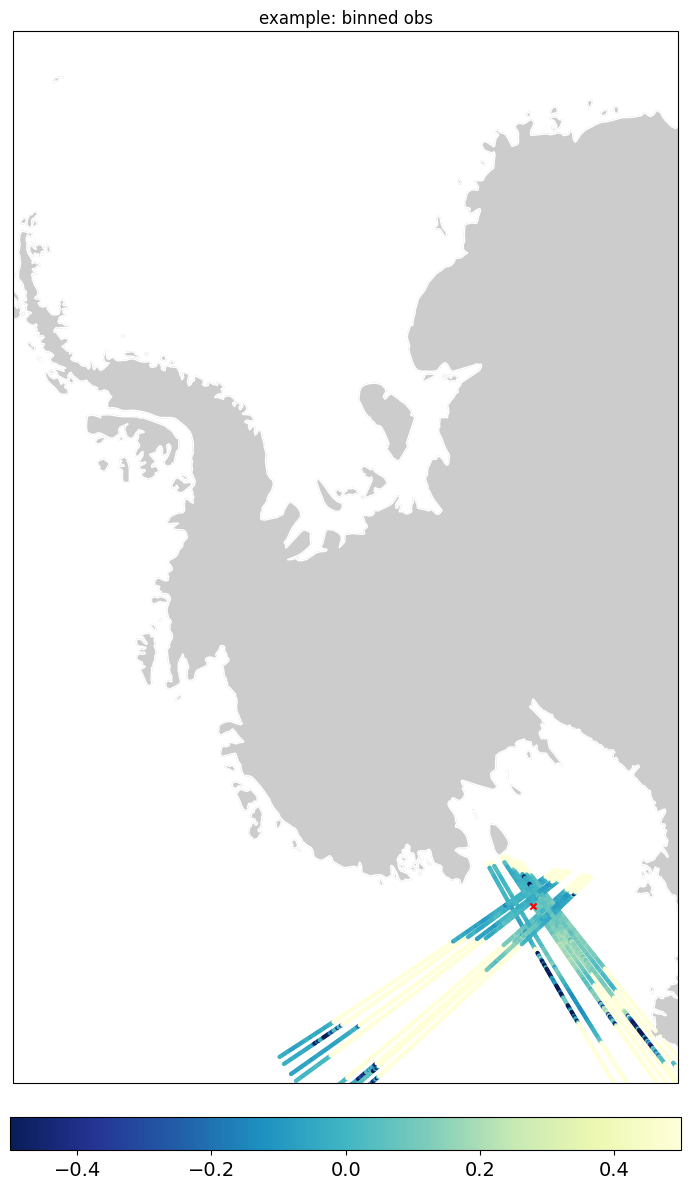

In [58]:
import re
import cartopy.feature as cfeat
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

all_data_df['lon'], all_data_df['lat'] = EASE2toWGS84(all_data_df['x'], all_data_df['y'])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('south'))

plot_pcolormesh(ax=ax,
                lon=all_data_df['lon'],
                lat=all_data_df['lat'],
                plot_data=all_data_df['obs'],
                title="example: binned obs",
                scatter=True,
                s=10,
                fig=fig,
                # extent=[-180, 180, -90, -60],
                extent=[10, -150, -80, -67],
                vmin=-0.5,vmax=0.5)

plt.scatter(x=-171.5, y=-77, s=20, marker='x', color='red', transform=ccrs.PlateCarree())
plt.tight_layout()
plt.show()

Now we proceed with GPSat, with the same process we went through in week 7.

In [59]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# TODO: allow for mounting of gdrive
# TODO: allow for checking out a branch

if IN_COLAB:

    import os
    import re

    # change to working directory
    work_dir = "/content"

    assert os.path.exists(work_dir), f"workspace directory: {work_dir} does not exist"
    os.chdir(work_dir)

    # clone repository
    !git clone https://github.com/CPOMUCL/GPSat.git

    repo_dir = os.path.join(work_dir, "GPSat")

    print(f"changing directory to: {repo_dir}")
    os.chdir(repo_dir)

fatal: destination path 'GPSat' already exists and is not an empty directory.
changing directory to: /content/GPSat


In [21]:
if IN_COLAB:
    !pip install -r requirements.txt

Ignoring gpflow: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment
Ignoring tensorflow: markers 'platform_system == "Windows"' don't match your environment
Ignoring tensorflow: markers 'platform_system == "Darwin" and platform_machine == "x86_64"' don't match your environment
Ignoring tensorflow-macos: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 7

In [22]:
if IN_COLAB:
    !pip install -e .

Obtaining file:///content/GPSat
  Preparing metadata (setup.py) ... done
  Running setup.py develop for GPSat


In [60]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GPSat import get_data_path, get_parent_path
from GPSat.dataprepper import DataPrep
from GPSat.utils import WGS84toEASE2_New, EASE2toWGS84_New, cprint, grid_2d_flatten, get_weighted_values
from GPSat.local_experts import LocalExpertOI, get_results_from_h5file
from GPSat.plot_utils import plot_pcolormesh, get_projection, plot_pcolormesh_from_results_data
from GPSat.config_dataclasses import DataConfig, ModelConfig, PredictionLocsConfig, ExpertLocsConfig
from GPSat.postprocessing import glue_local_predictions_2d
import cartopy.crs as ccrs
import cartopy.feature as cfeat

In [62]:
import pandas as pd

# savepath = '/Users/wg4031/Downloads/'
savepath = '/content/drive/MyDrive/Teaching_Michel/GEOL0069/StudentFolder/Week_8/'

# Load DataFrame from CSV file
# df = pd.read_csv(savepath+'all_data_01.csv')
df = pd.read_csv(savepath+'all_data_20.csv')

In [63]:
df

,x,y,t,obs
0,-1.158352e+06,-2.326781e+06,19358.786713,0.00040
1,-1.153165e+06,-2.322564e+06,19358.786725,-0.00385
2,-1.147980e+06,-2.318345e+06,19358.786736,-0.00705
3,-1.142795e+06,-2.314125e+06,19358.786748,-0.00705
4,-1.137610e+06,-2.309902e+06,19358.786759,-0.00675
...,...,...,...,...
4946,1.307158e+06,-3.217842e+06,19368.517847,0.01555
4947,1.311551e+06,-3.222704e+06,19368.517859,0.03775
4948,1.315944e+06,-3.227565e+06,19368.517870,0.10420
4949,1.320338e+06,-3.232424e+06,19368.517882,0.13745


In [64]:
x_Eddy, y_Eddy = WGS84toEASE2_New(lon=-171.5, lat=-77,lat_0=-90)

<ipython-input-64-571f612af049>:1: DeprecationWarning: Call to deprecated function (or staticmethod) WGS84toEASE2_New. (This function will be removed in future versions. Use `WGS84toEASE2` instead.)
  x_Eddy, y_Eddy = WGS84toEASE2_New(lon=-171.5, lat=-77,lat_0=-90)


In [65]:
# plt.scatter(df['lon'][df['lon']<-150][df['lat']<-72],df['lat'][df['lon']<-150][df['lat']<-72])
# plt.scatter(-171.5, -77, marker = 'x', color='red')

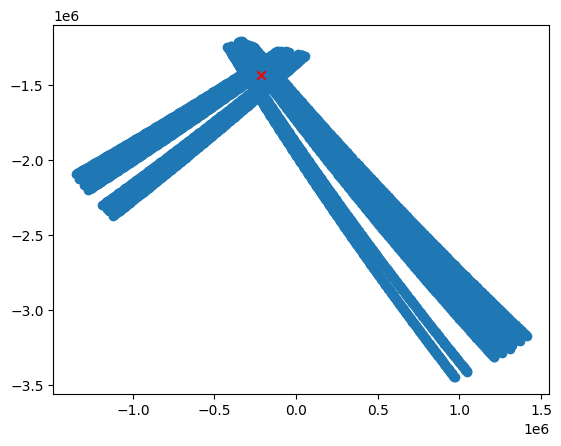

In [66]:
plt.scatter(df['x'],df['y'])
plt.scatter(x_Eddy, y_Eddy, marker = 'x', color='red')

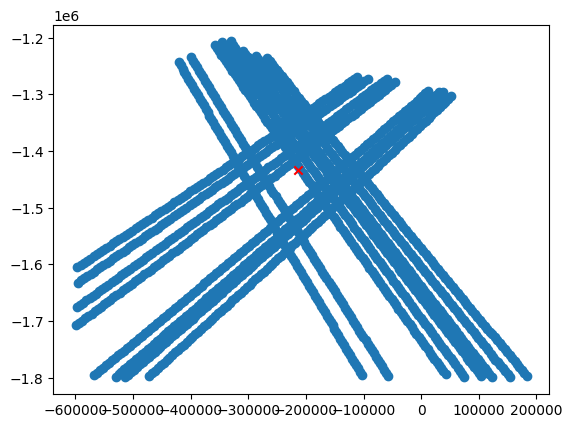

In [67]:
# condition=[df['x']<200000.0][df['x']>-600000.0][df['y']<-1000000.0][df['y']>-1800000.0]
plt.scatter(df['x'][df['x']<200000.0][df['x']>-600000.0][df['y']<-1000000.0][df['y']>-1800000.0],df['y'][df['x']<200000.0][df['x']>-600000.0][df['y']<-1000000.0][df['y']>-1800000.0])
plt.scatter(x_Eddy, y_Eddy, marker = 'x', color='red')

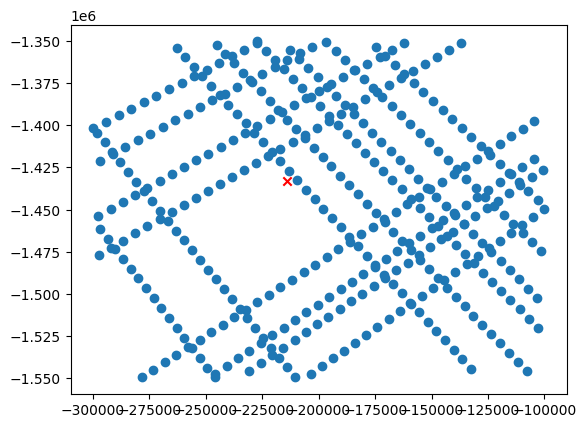

In [69]:
# condition=[df['x']<200000.0][df['x']>-600000.0][df['y']<-1000000.0][df['y']>-1800000.0]
plt.scatter(df['x'][df['x']<-100000.0][df['x']>-300000.0][df['y']<-1350000.0][df['y']>-1550000.0],df['y'][df['x']<-100000.0][df['x']>-300000.0][df['y']<-1350000.0][df['y']>-1550000.0])
plt.scatter(x_Eddy, y_Eddy, marker = 'x', color='red')

In [33]:
df['t']

0       19358.786713
1       19358.786725
2       19358.786736
3       19358.786748
4       19358.786759
            ...     
3104    19368.517859
3105    19368.517870
3106    19368.517882
3107    19368.517894
3108    19368.517905
Name: t, Length: 3109, dtype: float64

In [71]:
# - spaced every 10km for some x,y range
# xy_grid = grid_2d_flatten(x_range=[-600000.0, 200000.0],
#                           y_range=[-1800000.0, -1000000.0],
#                           step_size=100_000)
xy_grid = grid_2d_flatten(x_range=[-300000.0, -100000.0],
                          y_range=[-1550000.0, -1350000.0],
                          step_size=20_000)



# store in dataframe
eloc = pd.DataFrame(xy_grid, columns=['x', 'y'])

# add a time coordinate
eloc['t'] = np.floor(df['t'].mean())

print("Local expert locations:")
eloc.head()

Local expert locations:


,x,y,t
0,-290000.0,-1540000.0,19363.0
1,-270000.0,-1540000.0,19363.0
2,-250000.0,-1540000.0,19363.0
3,-230000.0,-1540000.0,19363.0
4,-210000.0,-1540000.0,19363.0


<ipython-input-72-543cd1096308>:2: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  eloc['lon'], eloc['lat'] = EASE2toWGS84_New(eloc['x'], eloc['y'],lat_0=-90)


'plot_pcolormesh': 0.010 seconds
'plot_pcolormesh': 0.033 seconds


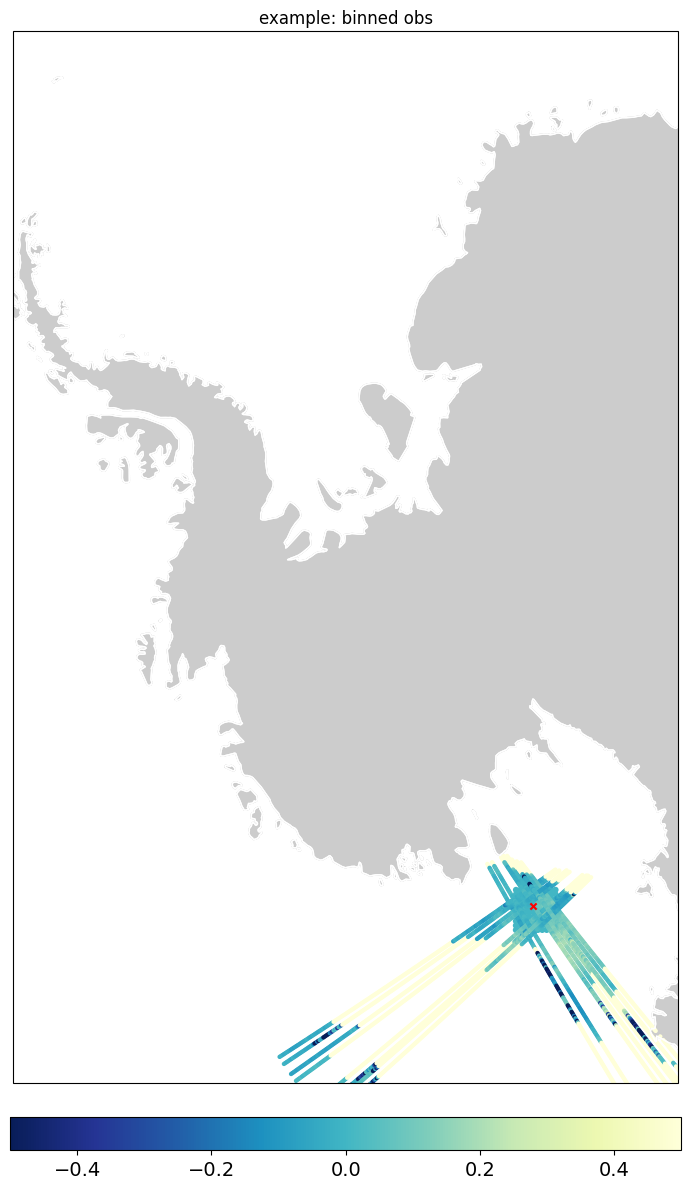

In [72]:
# plot expert locations
eloc['lon'], eloc['lat'] = EASE2toWGS84_New(eloc['x'], eloc['y'],lat_0=-90)


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('south'))

plot_pcolormesh(ax=ax,
                lon=eloc['lon'],
                lat=eloc['lat'],
                plot_data=0*eloc['t'],
                title="expert locations",
                scatter=True,
                s=20,
                extent=[10, -150, -80, -67],
                vmin=-0.5,vmax=0.5)

plot_pcolormesh(ax=ax,
                lon=all_data_df['lon'],
                lat=all_data_df['lat'],
                plot_data=all_data_df['obs'],
                title="example: binned obs",
                scatter=True,
                s=10,
                fig=fig,
                # extent=[-180, 180, -90, -60],
                extent=[10, -150, -80, -67],
                vmin=-0.5,vmax=0.5)

plt.scatter(x=-171.5, y=-77, s=20, marker='x', color='red', transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

In [73]:
# - spaced every 5km


# xy_grid = grid_2d_flatten(x_range=[-600000.0, 200000.0],
#                           y_range=[-1800000.0, -1000000.0],
#                           step_size=10_000)

xy_grid = grid_2d_flatten(x_range=[-300000.0, -100000.0],
                          y_range=[-1550000.0, -1350000.0],
                          step_size=5_000)


# store in dataframe
# NOTE: the missing 't' coordinate will be determine by the expert location
# - alternatively the prediction location can be specified
ploc = pd.DataFrame(xy_grid, columns=['x', 'y'])

# Add lon-lat measurements
ploc['lon'], ploc['lat'] = EASE2toWGS84_New(ploc['x'], ploc['y'], lat_0=-90)

print("Prediction locations:")
ploc

Prediction locations:


<ipython-input-73-ddfe51deed04>:19: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  ploc['lon'], ploc['lat'] = EASE2toWGS84_New(ploc['x'], ploc['y'], lat_0=-90)


,x,y,lon,lat
0,-297500.0,-1547500.0,-169.117906,-75.852711
1,-292500.0,-1547500.0,-169.296538,-75.861163
2,-287500.0,-1547500.0,-169.475381,-75.869477
3,-282500.0,-1547500.0,-169.654432,-75.877652
4,-277500.0,-1547500.0,-169.833687,-75.885688
...,...,...,...,...
1595,-122500.0,-1352500.0,-174.824670,-77.816683
1596,-117500.0,-1352500.0,-175.034829,-77.820664
1597,-112500.0,-1352500.0,-175.245123,-77.824480
1598,-107500.0,-1352500.0,-175.455545,-77.828131


In [77]:
# Set training and inference radius
training_radius = 100_000   # 300km
inference_radius = 50_000  # 200km

# Local expert locations config
local_expert = ExpertLocsConfig(source = eloc)

# Model config
model = ModelConfig(oi_model = "GPflowSVGPModel", # Use GPflow SVGP model
# model = ModelConfig(oi_model = "GPflowGPRModel", # Use GPflow GPR model
                    init_params = {
                        # normalise xy coordinates by 50km
                        "coords_scale": [10_000, 10_000, 1]
                        },
                    constraints = {
                        # set bounds on the lengthscale hyperparameters
                        "lengthscales": {
                            "low": [1e-08, 1e-08, 1e-08],
                            "high": [600_000, 600_000, 9]
                        }
                        }
                    )

# Data config
data = DataConfig(data_source = df,
                  obs_col = "obs",
                  coords_col = ["x", "y", "t"],
                  local_select = [
                    # Select data within 300km and ± 4 days of the expert location
                    {"col": "t", "comp": "<=", "val": 4},
                    {"col": "t", "comp": ">=", "val": -4},
                    {"col": ["x", "y"], "comp": "<", "val": training_radius}
                  ]
                )

# Prediction locs config
pred_loc = PredictionLocsConfig(method = "from_dataframe",
                                df = ploc,
                                max_dist = inference_radius)


In [78]:
locexp = LocalExpertOI(expert_loc_config = local_expert,
                       data_config = data,
                       model_config = model,
                       pred_loc_config = pred_loc)


'data_select': 0.000 seconds
'load': 0.001 seconds
in json_serializable - key: 'data_source' has value DataFrame/Series, but is too long: 4951 >  100
storing as str
in json_serializable - key: 'df' has value DataFrame/Series, but is too long: 1600 >  100
storing as str


In [ ]:
# path to store results
store_path = get_parent_path("results", "inline_example.h5")

# for the purposes of a simple example, if store_path exists: delete it
if os.path.exists(store_path):
    cprint(f"removing: {store_path}")
    os.remove(store_path)

# run optimal interpolation
locexp.run(store_path=store_path)

In [43]:
# extract, store in dict
dfs, _ = get_results_from_h5file(store_path)

print(f"tables in results file: {list(dfs.keys())}")


reading in results
getting all tables
merging on expert location data
table: 'oi_config' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations
tables in results file: ['expert_locs', 'inducing_chol', 'inducing_mean', 'inducing_points', 'kernel_variance', 'lengthscales', 'likelihood_variance', 'oi_config', 'preds', 'run_details']


In [80]:
dfs.keys()

dict_keys(['expert_locs', 'inducing_chol', 'inducing_mean', 'inducing_points', 'kernel_variance', 'lengthscales', 'likelihood_variance', 'oi_config', 'preds', 'run_details'])

In [81]:
dfs['lengthscales']

,x,y,t,_dim_0,lengthscales,lon,lat
0,-280000.0,-1530000.0,19363.0,0,22.605468,-169.629258,-76.037090
1,-280000.0,-1530000.0,19363.0,1,17.291273,-169.629258,-76.037090
2,-280000.0,-1530000.0,19363.0,2,7.905736,-169.629258,-76.037090
3,-240000.0,-1530000.0,19363.0,0,26.630315,-171.085073,-76.097564
4,-240000.0,-1530000.0,19363.0,1,21.315793,-171.085073,-76.097564
...,...,...,...,...,...,...,...
70,-160000.0,-1370000.0,19363.0,1,25.497599,-173.338698,-77.625020
71,-160000.0,-1370000.0,19363.0,2,8.289115,-173.338698,-77.625020
72,-120000.0,-1370000.0,19363.0,0,21.214836,-174.994167,-77.661652
73,-120000.0,-1370000.0,19363.0,1,17.804343,-174.994167,-77.661652


In [82]:
preds_data = dfs["preds"]
preds_data.head()

# multiple local experts may make predictions at the same prediction location (pred_loc).
# - for each prediction at a given location, take we weighted combination
# - weights being a function of the distance to each local expert that made a prediction at a given location.

plt_data = glue_local_predictions_2d(preds_df=preds_data,
                                     pred_loc_cols=["pred_loc_x", "pred_loc_y"],
                                     xprt_loc_cols=["x", "y"],
                                     vars_to_glue=["f*", "f*_var"],
                                     inference_radius=inference_radius)

plt_data.head()


,pred_loc_x,pred_loc_y,f*,f*_var
0,-297500.0,-1547500.0,0.082482,0.005691
1,-297500.0,-1542500.0,0.081341,0.005828
2,-297500.0,-1537500.0,0.079630,0.005984
3,-297500.0,-1532500.0,0.077376,0.006161
4,-297500.0,-1527500.0,0.074534,0.006374


<ipython-input-83-9edd7b7919e0>:2: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  eddylon,eddylat = EASE2toWGS84_New(x_Eddy,y_Eddy,lat_0=-90)
<ipython-input-83-9edd7b7919e0>:3: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  eloc['lon'],eloc['lat'] = EASE2toWGS84_New(eloc['x'],eloc['y'],lat_0=-90)
<ipython-input-83-9edd7b7919e0>:4: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  ploc['lon'],ploc['lat'] = EASE2toWGS84_New(ploc['x'],ploc['y'],lat_0=-90)
<ipython-input-83-9edd7b7919e0>:5: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` 

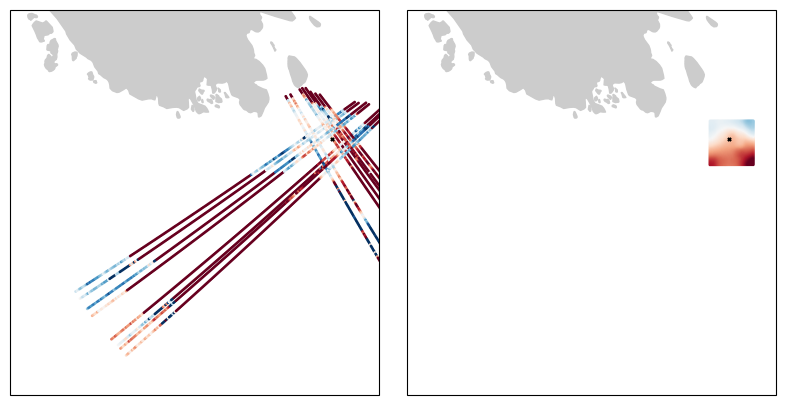

In [83]:
#inference 50 radius 100 loc 20km
eddylon,eddylat = EASE2toWGS84_New(x_Eddy,y_Eddy,lat_0=-90)
eloc['lon'],eloc['lat'] = EASE2toWGS84_New(eloc['x'],eloc['y'],lat_0=-90)
ploc['lon'],ploc['lat'] = EASE2toWGS84_New(ploc['x'],ploc['y'],lat_0=-90)
df['lon'],df['lat'] = EASE2toWGS84_New(df['x'],df['y'],lat_0=-90)
plt_data['lon'],plt_data['lat'] = EASE2toWGS84_New(plt_data['pred_loc_x'],plt_data['pred_loc_y'],lat_0=-90)

fig,ax = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection=ccrs.SouthPolarStereo()))
for c in range(2):
    ax[c].set_extent([-140, -180, -80, -67],ccrs.PlateCarree())
    ax[c].add_feature(cfeat.LAND,color=(0.8,0.8,0.8))
    #ax.scatter(eloc['lon'],eloc['lat'],s=1,color='r',transform=ccrs.PlateCarree())
    #ax.scatter(ploc['lon'],ploc['lat'],s=1,color='b',transform=ccrs.PlateCarree())
    if c == 0:
        ax[c].scatter(df['lon'],df['lat'],c=df['obs'],s=1,cmap='RdBu_r',vmin=-0.1,vmax=0.1,transform=ccrs.PlateCarree())
    else:
        ax[c].scatter(plt_data['lon'],plt_data['lat'],c=plt_data['f*'],s=1,cmap='RdBu_r',vmin=-0.1,vmax=0.1,transform=ccrs.PlateCarree())
    ax[c].scatter(eddylon,eddylat,s=5,color='k',transform=ccrs.PlateCarree(),marker='x')
plt.subplots_adjust(wspace=0.05)
plt.show()

<ipython-input-47-265660360240>:1: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  eddylon,eddylat = EASE2toWGS84_New(x_Eddy,y_Eddy,lat_0=-90)
<ipython-input-47-265660360240>:2: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  eloc['lon'],eloc['lat'] = EASE2toWGS84_New(eloc['x'],eloc['y'],lat_0=-90)
<ipython-input-47-265660360240>:3: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  ploc['lon'],ploc['lat'] = EASE2toWGS84_New(ploc['x'],ploc['y'],lat_0=-90)
<ipython-input-47-265660360240>:4: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` 

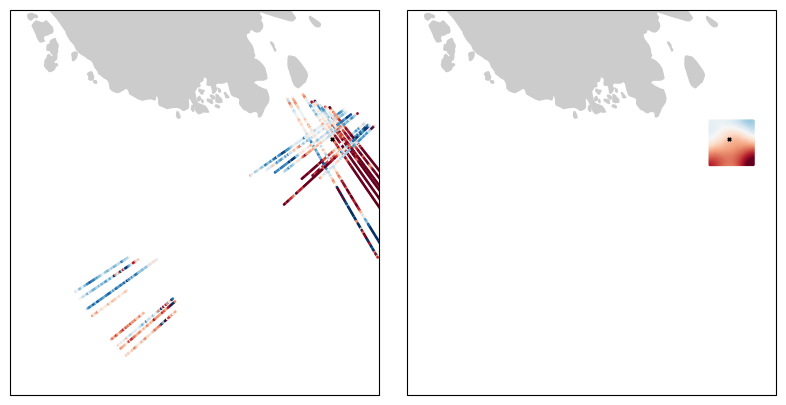

In [47]:
#inference 100 radius 300 loc 40km
eddylon,eddylat = EASE2toWGS84_New(x_Eddy,y_Eddy,lat_0=-90)
eloc['lon'],eloc['lat'] = EASE2toWGS84_New(eloc['x'],eloc['y'],lat_0=-90)
ploc['lon'],ploc['lat'] = EASE2toWGS84_New(ploc['x'],ploc['y'],lat_0=-90)
df['lon'],df['lat'] = EASE2toWGS84_New(df['x'],df['y'],lat_0=-90)
plt_data['lon'],plt_data['lat'] = EASE2toWGS84_New(plt_data['pred_loc_x'],plt_data['pred_loc_y'],lat_0=-90)

fig,ax = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection=ccrs.SouthPolarStereo()))
for c in range(2):
    ax[c].set_extent([-140, -180, -80, -67],ccrs.PlateCarree())
    ax[c].add_feature(cfeat.LAND,color=(0.8,0.8,0.8))
    #ax.scatter(eloc['lon'],eloc['lat'],s=1,color='r',transform=ccrs.PlateCarree())
    #ax.scatter(ploc['lon'],ploc['lat'],s=1,color='b',transform=ccrs.PlateCarree())
    if c == 0:
        ax[c].scatter(df['lon'],df['lat'],c=df['obs'],s=1,cmap='RdBu_r',vmin=-0.1,vmax=0.1,transform=ccrs.PlateCarree())
    else:
        ax[c].scatter(plt_data['lon'],plt_data['lat'],c=plt_data['f*'],s=1,cmap='RdBu_r',vmin=-0.1,vmax=0.1,transform=ccrs.PlateCarree())
    ax[c].scatter(eddylon,eddylat,s=5,color='k',transform=ccrs.PlateCarree(),marker='x')
plt.subplots_adjust(wspace=0.05)
plt.show()

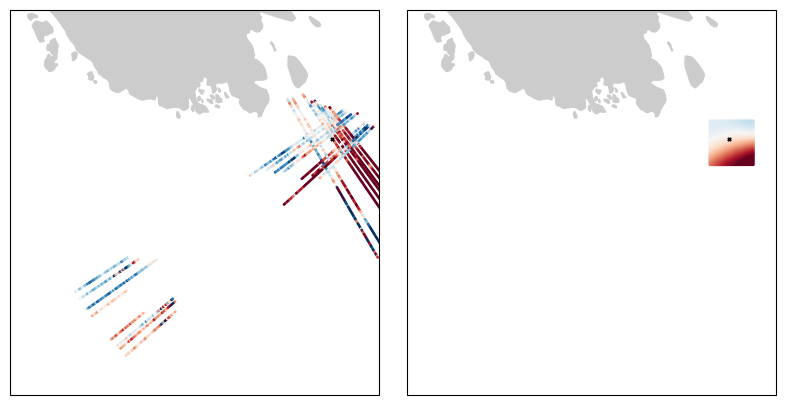

In [ ]:
eddylon,eddylat = EASE2toWGS84_New(x_Eddy,y_Eddy,lat_0=-90)
eloc['lon'],eloc['lat'] = EASE2toWGS84_New(eloc['x'],eloc['y'],lat_0=-90)
ploc['lon'],ploc['lat'] = EASE2toWGS84_New(ploc['x'],ploc['y'],lat_0=-90)
df['lon'],df['lat'] = EASE2toWGS84_New(df['x'],df['y'],lat_0=-90)
plt_data['lon'],plt_data['lat'] = EASE2toWGS84_New(plt_data['pred_loc_x'],plt_data['pred_loc_y'],lat_0=-90)

fig,ax = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection=ccrs.SouthPolarStereo()))
for c in range(2):
    ax[c].set_extent([-140, -180, -80, -67],ccrs.PlateCarree())
    ax[c].add_feature(cfeat.LAND,color=(0.8,0.8,0.8))
    #ax.scatter(eloc['lon'],eloc['lat'],s=1,color='r',transform=ccrs.PlateCarree())
    #ax.scatter(ploc['lon'],ploc['lat'],s=1,color='b',transform=ccrs.PlateCarree())
    if c == 0:
        ax[c].scatter(df['lon'],df['lat'],c=df['obs'],s=1,cmap='RdBu_r',vmin=-0.1,vmax=0.1,transform=ccrs.PlateCarree())
    else:
        ax[c].scatter(plt_data['lon'],plt_data['lat'],c=plt_data['f*'],s=1,cmap='RdBu_r',vmin=-0.1,vmax=0.1,transform=ccrs.PlateCarree())
    ax[c].scatter(eddylon,eddylat,s=5,color='k',transform=ccrs.PlateCarree(),marker='x')
plt.subplots_adjust(wspace=0.05)
plt.show()

In [ ]:
plt_data.shape

(1600, 4)

In [84]:
x_grid=np.asarray(plt_data['pred_loc_x']).reshape(40,40,order='C')
y_grid=np.asarray(plt_data['pred_loc_y']).reshape(40,40,order='C')
z_grid=np.asarray(plt_data['f*']).reshape(40,40,order='C')
v_grid=np.asarray(plt_data['f*_var']).reshape(40,40)

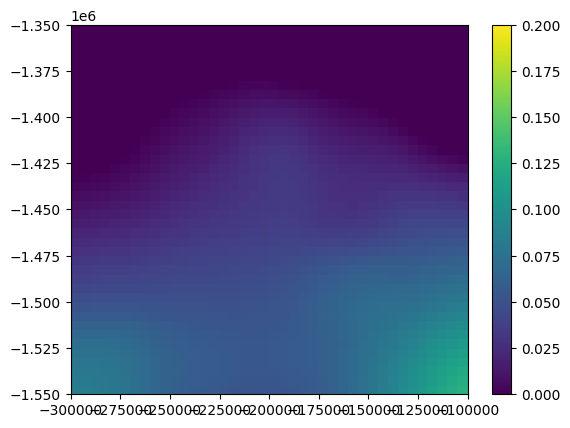

In [85]:
#inference 50 radius 100 loc 20km
plt.pcolor(x_grid,y_grid,z_grid,vmin=0,vmax=0.2)
plt.colorbar()

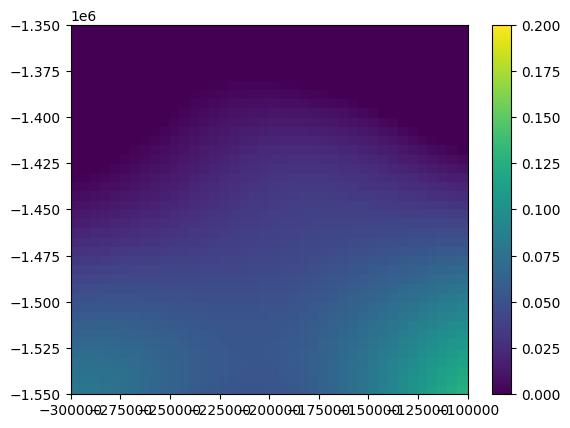

In [49]:
#inference 100 radius 300 loc 40km
plt.pcolor(x_grid,y_grid,z_grid,vmin=0,vmax=0.2)
plt.colorbar()

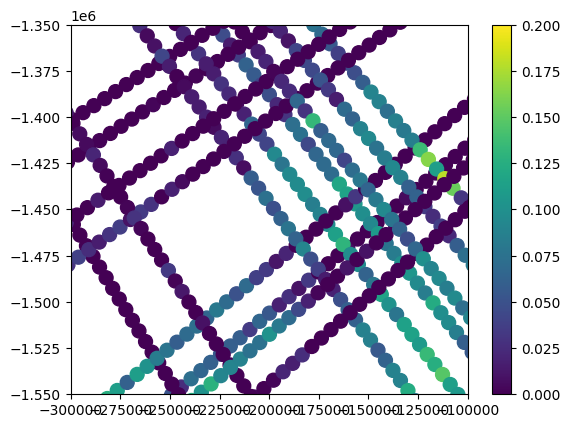

In [50]:
plt.scatter(all_data_df['x'], all_data_df['y'], c=all_data_df['obs'], s=100, vmin=0, vmax=0.2)  # 'obs' as both color and size
plt.xlim((-300000.0, -100000.0))
plt.ylim((-1550000.0, -1350000.0))
plt.colorbar()  # Add colorbar to show the mapping of 'obs' values to colors
plt.show()

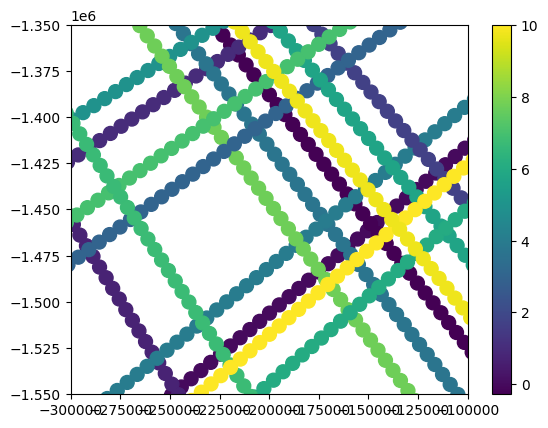

In [51]:
plt.scatter(all_data_df['x'], all_data_df['y'], c=all_data_df['t']-19358.786713, s=100)#, vmin=0, vmax=0.2)  # 'obs' as both color and size
plt.xlim((-300000.0, -100000.0))
plt.ylim((-1550000.0, -1350000.0))
plt.colorbar()  # Add colorbar to show the mapping of 'obs' values to colors
plt.show()